<a href="https://colab.research.google.com/github/ninarina12/phononDoS_tutorial/blob/main/phononDoS_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial | Predicting phonon DoS with `e3nn`
### Getting started
*   Go to Runtime > Change runtime type, and select GPU.
*   Clone the GitHub repository to access the tutorial files:

*   Install some relevant packages (should take < 1 minute).



### Tutorial

In [2]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import HTML
import pandas as pd

# utilities
import time
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, plot_partials,
                              palette, colors, cmap)
from utils.utils_model import Network, visualize_layers, train
from utils.utils_plot import plotly_surface, plot_orbitals, get_middle_feats

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

In [3]:
# pad the gamma-phjonon data with zero, or cut the lengthy part.
def tosize(a, n):
    """_summary_

    Args:
        a (np.array): gamma-phonon 
        n (int): length of the gamma phonon data after padding/cutting data.

    Returns:
        np.array: 
    """
    a = np.asarray(a)
    x = np.zeros(n, dtype=a.dtype)
    m = min(n, len(a))
    x[:m] = a[:m]
    return x

### Data provenance
We train our model using the database of Density Functional Perturbation Theory (DFPT)-calculated phonon densities of states (DoS), containing approximately 1,500 crystalline solids [[Petretto et al. 2018]](https://doi.org/10.1038/sdata.2018.65).

In [4]:
df = pd.read_pickle(f'data/df_struct_phonon.pkl')
species = sorted(list(set(df['species'].sum())))
from dataframe_v1 import tosize
df['gph'] = df['g_phs'].map(lambda x: tosize(x, 48))

  8%|▊         | 118/1521 [00:00<00:02, 569.95it/s]

Gamma point for use:  50
g_phs [  4.12316254   4.12316254  10.89725318  95.71104399  95.71104399
 135.72411667]
Gamma point for use:  66
g_phs [  0.           0.           0.         551.4723697  551.4723697
 644.47470924]
Gamma point for use:  74
g_phs [ 16.2765513   16.2765513   21.81149848 662.34727953 662.34727953
 777.02495496]
Gamma point for use:  71
g_phs [ 15.5682353   15.5682353   21.18099809 690.63109361 690.63109361
 694.52413808]
Gamma point for use:  53
g_phs [  3.07369652   3.07369652  10.40738869 205.13800584 205.13800584
 259.79848089]
Gamma point for use:  43
g_phs [   8.2240676     9.25406088   15.02207989  116.70889087  117.59733494
  131.18660959  173.86640481  325.67862491  341.48460808  893.20798671
  923.38805915 1131.18014554]
Gamma point for use:  62
g_phs [ 10.83243419  17.37763456  26.43193888 252.30941768 256.33321365
 434.6403666  568.5901231  617.70313847 622.55739975 671.40919716
 688.70186284 813.78154807]
Gamma point for use:  57
g_phs [ 19.30219573  2

 15%|█▌        | 233/1521 [00:00<00:02, 562.07it/s]

Gamma point for use:  2
g_phs [  0.           0.           0.           8.53715745   8.53715749
 130.36965198 135.79671918 135.79671919 142.07969232 149.72804853
 149.79252709 164.75574088 232.48267355 245.56935306 255.04241516
 256.95805242 272.61579312 275.40622936 276.56520269 284.29559613
 420.47477615 420.47477616 421.55439642 437.11634649 566.3028335
 567.08530126 603.66661351 606.8301358  739.79718801 836.40499232]
Gamma point for use:  51
g_phs [ 10.62451501  10.88269324  22.43534623 152.15793449 207.52398794
 213.8492397  217.22693064 230.23444138 232.67459161 271.84062751
 280.0794188  280.18943124 313.24293028 314.48803258 325.19011302
 327.07461494 375.53869966 416.89561231 417.40430909 452.21127496
 457.05377421 516.56357628 537.07809754 544.05026883 549.80816125
 598.77637208 658.07821143 658.09879166 673.15422197 676.88597123]
Gamma point for use:  0
g_phs [-35.89755926   0.           0.           0.          60.43541464
  74.84987383  74.84987383  94.85293111 117.787612

 23%|██▎       | 348/1521 [00:00<00:02, 565.22it/s]

Gamma point for use:  60
g_phs [-8.71157559e-03 -8.65068459e-03  0.00000000e+00  6.06391212e+02
  6.06391279e+02  7.03076578e+02  7.03387818e+02  7.66363066e+02
  7.75373323e+02  8.24896275e+02  8.40707548e+02  8.47520836e+02
  8.80789020e+02  8.83028131e+02  8.83031537e+02  9.40585569e+02
  9.46215874e+02  9.47839050e+02  9.65297947e+02  9.69719413e+02
  9.71746051e+02  1.06857191e+03  1.08385664e+03  1.23134391e+03]
Gamma point for use:  54
g_phs [-7.28660326e-03 -7.19478998e-03 -6.99135625e-03  4.35458298e+02
  4.35549189e+02  4.94703874e+02  5.01746789e+02  5.27152685e+02
  5.35085783e+02  6.49378124e+02  6.49654464e+02  6.51046715e+02
  6.78483845e+02  6.83857197e+02  6.92934224e+02  7.08942702e+02
  7.54942862e+02  7.58672747e+02  8.17058534e+02  8.22359607e+02
  8.62081137e+02  8.64232677e+02  8.86565260e+02  1.04837118e+03]
Gamma point for use:  45
g_phs [  6.90467564   6.90467564   9.42341784  90.22060902  90.22060902
 117.70645388 145.08430543 145.08430543 148.0154339  149.91

 30%|███       | 462/1521 [00:00<00:01, 554.14it/s]

Gamma point for use:  58
g_phs [  5.22695604   5.22695604   8.92314321 160.79753227 160.79753227
 286.24212398]
Gamma point for use:  47
g_phs [  3.09820195   3.09820195   8.78144723  75.46810973  75.46810973
 125.12635584]
Gamma point for use:  47
g_phs [ 2.49044318  2.49044318  7.81333976 73.55872286 73.55872286 99.84117289]
Gamma point for use:  0
g_phs [-14.12929673   0.           0.           0.          72.51802163
  77.97086528  94.41676837  96.58460497 155.09821417 155.09821417
 206.37919532 212.83238433 219.50633241 219.85092408 223.66662316
 238.65369637 248.38640444 313.87621259]
Gamma point for use:  67
g_phs [  9.77324217   9.77324217  15.51792248 206.55387166 206.55387166
 399.33631835]
Gamma point for use:  47
g_phs [  3.76773823   3.76773823   7.278528    68.87636933  68.87636933
 109.01805476]
Gamma point for use:  41
g_phs [-6.62892737e-03 -6.51594810e-03 -2.87686444e-03  6.41079829e+01
  6.77046596e+01  9.48736090e+01  9.62238404e+01  1.01688765e+02
  1.05324025e+02 

 38%|███▊      | 573/1521 [00:01<00:01, 545.12it/s]

Gamma point for use:  40
g_phs [-3.78675797e-03 -2.26385853e-03  0.00000000e+00  9.46020603e+01
  9.63283067e+01  1.08347065e+02  1.08692942e+02  1.09356999e+02
  1.11242080e+02  1.30645658e+02  1.31002401e+02  1.41501257e+02
  1.46179981e+02  1.52492840e+02  1.57563677e+02  1.58534246e+02
  1.62302142e+02  1.73098671e+02  1.73490443e+02  1.84385912e+02
  1.84396637e+02  1.87761751e+02  1.93551440e+02  2.02824620e+02
  2.04148940e+02  2.09467314e+02  2.11483330e+02  2.17592805e+02
  2.39613489e+02  2.44306790e+02  2.49254047e+02  2.53204170e+02
  2.56109483e+02  2.59792078e+02  2.63918505e+02  2.85405507e+02]
Gamma point for use:  62
g_phs [  8.75926574   8.75926574  12.56492058 470.66638562 470.66638562
 502.19614513]
Gamma point for use:  53
g_phs [  7.07507302   7.07507302  10.628148   258.76491189 258.76491189
 305.48775406 306.03179067 306.03179067 332.59025528]
Gamma point for use:  55
g_phs [-2.04816017e-02 -2.03627568e-02  0.00000000e+00  7.30470051e+01
  7.30470051e+01  1.3474

 45%|████▍     | 682/1521 [00:01<00:01, 534.40it/s]

Gamma point for use:  0
g_phs [-1.11075428e-01 -8.45374892e-02 -2.81556123e-02  2.74596389e+02
  2.83947212e+02  2.87482832e+02  2.99254048e+02  3.22609459e+02
  3.28482387e+02  3.55130732e+02  3.75481681e+02  4.06470567e+02
  4.24453738e+02  4.24587537e+02  4.25219264e+02  4.53502724e+02
  4.72914515e+02  5.00413504e+02  5.19365877e+02  5.58647816e+02
  5.61258544e+02  5.65603042e+02  5.92438887e+02  6.06759948e+02
  6.13725526e+02  6.29815155e+02  6.82515304e+02  6.97697499e+02
  7.15207267e+02  8.10568080e+02  8.33207433e+02  8.88143395e+02
  9.00908540e+02  1.02092554e+03  1.02159749e+03  1.08148575e+03]
Gamma point for use:  41
g_phs [  3.86089904   4.96859946   8.35345236  36.73205154  37.54213809
  61.03098412  61.6828761   66.03017858  75.26958684 104.38657309
 104.54738581 107.45197225 109.04128765 111.6332346  113.35177349
 116.66852726 120.75976201 120.86010336 139.15892573 200.53360898
 229.83245127]
Gamma point for use:  90
g_phs [  5.0853225    9.48411327  14.62314187  46

 52%|█████▏    | 789/1521 [00:01<00:01, 526.11it/s]

Gamma point for use:  108
g_phs [ 10.50909338  10.50909338  20.27090205  95.42111859  95.42111859
 132.92052353 180.76190408 180.88043166 180.88043166 190.30915792
 190.30915792 366.09219876 499.38197787 499.38197787 690.69873074]
Gamma point for use:  38
g_phs [  5.02059863   6.80192986  11.23530256  56.01903857  56.83561172
  71.91571303  73.81711396  75.31085938  79.3600391  133.21397974
 133.44394659 148.0143069  156.17586193 156.45197202 169.14679557
 181.6865001  182.03400712 185.56985863 194.89116799 195.65622605
 196.12735408 204.46572595 205.3669854  209.16563291]
Gamma point for use:  0
g_phs [-3.68196142e-03 -2.23026289e-03  0.00000000e+00  1.22240099e+02
  1.28244554e+02  1.43340949e+02  1.50474449e+02  1.54913900e+02
  1.59946525e+02  1.65674572e+02  1.92996577e+02  2.12944960e+02
  2.35214961e+02  2.37356287e+02  2.68700723e+02  2.78711681e+02
  3.03434193e+02  3.11159873e+02  3.28188829e+02  3.64805904e+02
  3.88276856e+02  4.00830793e+02  4.10939763e+02  4.16281126e+02


 55%|█████▌    | 842/1521 [00:01<00:01, 517.13it/s]

Gamma point for use:  60
g_phs [-6.51496746e-03 -5.65378875e-03 -4.95847440e-03  6.74850297e+01
  1.36761001e+02  1.96440674e+02  2.04358796e+02  2.36082017e+02
  2.41962276e+02  2.43574722e+02  2.50818590e+02  3.48260694e+02
  3.59295201e+02  3.73256352e+02  3.87551562e+02  3.87931798e+02
  4.04596187e+02  4.16863890e+02  4.29223017e+02  4.65829666e+02
  5.16071475e+02  5.31239581e+02  5.53081243e+02  5.53668371e+02
  6.36318316e+02  7.02987246e+02  9.62677676e+02  1.02098010e+03
  1.05583573e+03  1.09313968e+03  1.09483054e+03  1.10883681e+03
  1.19975463e+03]
Gamma point for use:  33
g_phs [  2.008185     2.41011791   7.38244845  24.47514304  24.77899131
  38.79982932  39.91189973  48.42260647  53.1045057   53.26992554
  53.48118891  54.59670349  58.56244884  59.36685826  62.03492558
  62.10567337  62.4092528   67.63879255 106.97583643 114.72171835
 114.79631572 114.83068082 122.67674922 172.80630377 190.25022403
 256.63739224 260.0185257 ]
Gamma point for use:  54
g_phs [  0.      

 62%|██████▏   | 945/1521 [00:01<00:01, 507.41it/s]

Gamma point for use:  47
g_phs [  4.968381     4.968381    11.27494889 130.03987353 130.03987353
 163.06149887 163.52363515 163.52363515 204.88027124]
Gamma point for use:  60
g_phs [  3.25065016   4.00483701  11.57347002  22.86967316  28.36943826
  31.96836568  32.83467286  33.51283496  37.79108327  39.69679147
  41.47666059  43.08136646  44.59644461  46.68434072  47.11878669
  48.33453047  53.44553281  54.11332929  62.23967808  65.05745109
  70.72025405  73.05522907  76.85481418  83.91475551 100.21211174
 122.93266272 149.80376045 175.86484006 177.82379942 194.33788691]
Gamma point for use:  35
g_phs [  3.87855389   4.54657417   7.6532471   37.23036755  37.78864109
  72.23257952  75.4697426   76.51344137  77.64124286  89.17247645
  91.12432112  93.98570278  94.82120513 117.66836413 118.33623648
 127.95984771 138.7077886  140.21288782 144.34787658 150.14964217
 181.0848138  217.09613712 226.75630144 232.72257499]
Gamma point for use:  33
g_phs [-15.09177238 -15.09177236 -15.09177236  

 69%|██████▉   | 1046/1521 [00:01<00:00, 497.62it/s]

Gamma point for use:  0
g_phs [-4.89942922e-03 -3.39130245e-03 -2.40238019e-03  8.22557985e+01
  8.48877852e+01  1.07158616e+02  1.18056053e+02  1.31961607e+02
  1.41643307e+02  1.52207802e+02  1.64185454e+02  1.75741832e+02
  1.78474771e+02  1.85061756e+02  1.85583482e+02  1.98069253e+02
  1.98750615e+02  2.05050579e+02  2.10086102e+02  2.23210172e+02
  2.45585512e+02  2.45662772e+02  2.66089274e+02  3.32073875e+02
  5.49323826e+02  5.53201889e+02  5.65518486e+02  5.74950859e+02
  7.60328809e+02  7.61669879e+02  8.95332289e+02  8.96425311e+02
  1.21053827e+03  1.21372139e+03  1.21934894e+03  1.27389401e+03]
Gamma point for use:  40
g_phs [-84.25567441 -84.2556744  -84.2556744    0.           0.
   0.          45.72615209  45.72615211  59.06150394  59.06150395
  59.06150396  92.11615495  92.11615495  92.11615496 117.22681966
 177.36069193 177.36069193 205.18694228 205.18694228 205.18694228
 231.52775531 247.47647271 247.47647271 255.40704714 394.83339857
 394.83339857 475.14881639 475.

 75%|███████▌  | 1148/1521 [00:02<00:00, 503.01it/s]

Gamma point for use:  23
g_phs [  2.46585239   3.66265964   6.73847422   8.27174107  22.63670859
  28.37982969  28.70784876  29.47620982  30.24637678  39.91325457
  58.7785901   59.53952173  64.28853261  64.94622404  75.88429698
  76.60523706  80.34244254  88.10742806  95.96512968  96.29501253
 101.10067952 112.31661694 117.1288643  127.23811274 127.43189999
 129.13371915 147.66852132]
Gamma point for use:  131
g_phs [-3.71423469e-03 -2.33731062e-03  0.00000000e+00  1.31734903e+02
  1.60103505e+02  1.67878545e+02  2.29822646e+02  3.39267374e+02
  4.67368936e+02  5.31549682e+02  5.34829214e+02  5.81436263e+02]
Gamma point for use:  48
g_phs [-2.54431286e-03  0.00000000e+00  0.00000000e+00  1.03078820e+02
  1.31057937e+02  1.31057937e+02  1.45093930e+02  1.46952402e+02
  1.52126848e+02  1.56298669e+02  2.20692985e+02  2.20692985e+02
  2.67126877e+02  2.67126877e+02  2.86821267e+02  3.09765628e+02
  3.23465066e+02  3.29939091e+02  4.06493141e+02  4.06493141e+02
  4.31827968e+02  4.6013703

 86%|████████▌ | 1306/1521 [00:02<00:00, 513.89it/s]

Gamma point for use:  65
g_phs [  5.87760995   6.05532293  12.20574583 103.21988499 103.72157415
 183.08342003 233.34037102 234.98382198 256.59038052 320.42844605
 414.17308578 428.1145569 ]
Gamma point for use:  62
g_phs [  5.30225457   5.82418648  11.6103077   71.2790784   71.80453155
 133.37977024 231.62693983 233.83430304 246.36145969 308.82107856
 409.30823341 413.09582096]
Gamma point for use:  62
g_phs [  2.40182192   2.40182192  11.63660988 186.13573489 186.13573489
 235.23568514 236.81535544 236.81535544 322.79313814]
Gamma point for use:  53
g_phs [-2.43187165e-03 -2.31686749e-03  0.00000000e+00  1.30179200e+02
  1.30179200e+02  1.55683463e+02  1.57769651e+02  1.66120214e+02
  2.11923649e+02  2.30609950e+02  2.38800559e+02  2.38800559e+02
  2.49185892e+02  2.90701336e+02  2.95438039e+02  2.98132733e+02
  3.34626539e+02  4.29329173e+02  7.23012251e+02  7.23012251e+02
  7.24367631e+02  7.25219869e+02  8.12875486e+02  8.14385188e+02
  1.07923155e+03  1.08082019e+03  1.35205999e+

 93%|█████████▎| 1411/1521 [00:02<00:00, 515.40it/s]

Gamma point for use:  36
g_phs [-4.94773129e-03  0.00000000e+00  0.00000000e+00  1.10379473e+02
  1.23285176e+02  1.26393146e+02  1.35844262e+02  2.27329537e+02
  2.27329537e+02  2.63853193e+02  2.86804898e+02  3.07176202e+02
  3.07176202e+02  3.25694222e+02  3.28967836e+02  5.03245020e+02
  5.03245020e+02  5.06662095e+02  5.42277187e+02  5.44729779e+02
  5.45285094e+02  5.64107471e+02  6.28167968e+02  6.28167968e+02
  6.31122435e+02  6.32571075e+02  6.64430964e+02]
Gamma point for use:  56
g_phs [  2.86636928   4.94581024  12.55252381  62.45245516  64.4160394
  65.70561817  73.45103166  78.32648973  83.2978942   87.05436177
  87.27834447  92.77008379  94.45007484  96.28205025 100.70845856
 103.10094229 109.6729261  115.89115506 126.08694222 127.67329982
 136.76340256 159.80064806 169.46506043 201.43314868 211.76515729
 216.16569518 247.36834402 257.06259193 261.94679805 269.32691752]
Gamma point for use:  54
g_phs [  2.08194459   3.65045779   9.2446745   37.31886325  51.02882684
  53.

 96%|█████████▌| 1463/1521 [00:02<00:00, 501.28it/s]

Gamma point for use:  24
g_phs [  6.24757169   7.33491943  10.87762333  67.93092894  67.95510382
  72.96872361  81.69447427  83.05084192  96.92196182 129.71327764
 133.94441356 135.86125849 144.57022634 154.76016743 160.06527376
 160.34046332 162.81993018 166.57820943 166.90214837 168.5474966
 176.51118044 181.67301298 194.7858722  197.42983606 207.39514025
 207.51569993 241.76854442]
Gamma point for use:  44
g_phs [-4.52448951e-03 -4.48691700e-03 -3.90642844e-03  1.67357435e+02
  1.74744332e+02  1.74852912e+02  1.85413997e+02  1.85413997e+02
  1.99254957e+02  2.11882976e+02  2.11882976e+02  2.29095985e+02
  2.82351742e+02  2.82351742e+02  3.00531587e+02  3.00836735e+02
  3.03921792e+02  3.21880897e+02  3.43612495e+02  3.43612495e+02
  3.57045145e+02  3.57057329e+02  3.61672170e+02  3.61692450e+02
  3.88064810e+02  3.88064810e+02  3.93093978e+02  3.99826648e+02
  4.13893378e+02  4.35084453e+02]
Gamma point for use:  127
g_phs [  3.54712661   5.74253763   6.0696633   36.02219151  67.812

100%|██████████| 1521/1521 [00:02<00:00, 522.44it/s]


Gamma point for use:  46
g_phs [  3.53063434   4.44573228   7.81498849  31.08515961  32.23424468
  37.62068917  42.2494046   45.78530125  50.56598078  50.83579534
  51.28800695  55.62519834  58.45748918  59.59141496  61.0114016
  66.1950511   67.34379595  73.14464267  78.21628851  91.78321464
  92.44640581 103.25164525 109.50804447 124.80305073 139.29017684
 141.40462631 143.19291704 149.01847573 156.57508153 164.52726499]
Gamma point for use:  48
g_phs [  9.61279162   9.61279162  18.13945554 106.14470986 106.14470986
 122.42038697 185.99524922 185.99524922 205.96031872 206.02992374
 206.02992374 379.07878553 514.65164167 514.65164167 673.13136911]
Gamma point for use:  52
g_phs [  4.43996473   5.68482085   9.86338523  39.49764527  40.03225389
  45.8736325   53.18955525  55.02794429  56.88602158  64.69703352
  71.73636804  72.33111517  72.36677811  84.19216089  89.22802541
  91.9513088   94.08895296 106.24461106 108.22651032 111.49472422
 112.36164211 114.11773463 120.2179093  148.5915

In [5]:
len(df)

1521

### Data structures
Crystal structures are represented as [ASE](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#the-atoms-object) (Atomic Simulation Environment) `Atoms` objects, which store the atomic species and positions of each atom in the unit cell, as well as the lattice vectors of the unit cell.

Text(0.5, 0.98, 'mp-12442 / AuF6K')

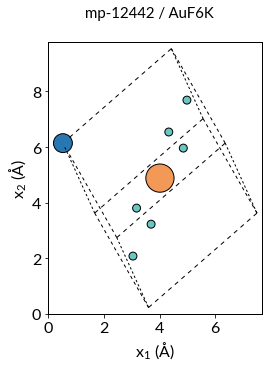

In [6]:
# plot an example structure
i = 120 # structure index in dataframe

struct = df.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

fig, ax = plt.subplots(figsize=(6,5))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('30x,30y,0z'))

ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$');
fig.patch.set_facecolor('white')
fig.suptitle(f"{df.iloc[i]['id']} / {df.iloc[i]['formula']}", fontsize=15)

average lattice parameter (a/b/c): 5.792654504656975 / 5.864983679194617 / 6.50231735239098


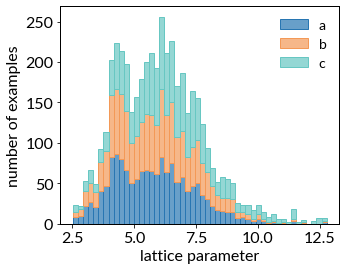

In [7]:
# lattice parameter statistics
def get_lattice_parameters(df):
    a = []
    for entry in df.itertuples():
        a.append(entry.structure.cell.cellpar()[:3])
    return np.stack(a)

a = get_lattice_parameters(df)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for d, c, n in zip(['a', 'b', 'c'], colors.values(), [a[:,0], a[:,1], a[:,2]]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('lattice parameter')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average lattice parameter (a/b/c):', a[:,0].mean(), '/', a[:,1].mean(), '/', a[:,2].mean())

### Feature representation
We construct the inputs to our neural network following the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/guide/periodic_boundary_conditions.html) on handling point inputs with periodic boundary conditions. For a given crystal, each atom in the unit cell is associated with a feature vector that one-hot encodes its atomic mass in the index corresponding to its atomic number. The unit cell of the crystal is encoded as a graph in which two atoms (nodes) are joined by an edge if they are within a cutoff radius `r_max` of one another.

In [8]:
# one-hot encoding atom type and mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, 119), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))

100%|██████████| 118/118 [00:00<00:00, 86089.38it/s]


In [9]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x=am_onehot[[type_encoding[specie] for specie in symbols]],   # atomic mass (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]], # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        gph=torch.from_numpy(entry.gph).unsqueeze(0)
    )
    
    return data

r_max = 4. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 1521/1521 [00:11<00:00, 132.97it/s]


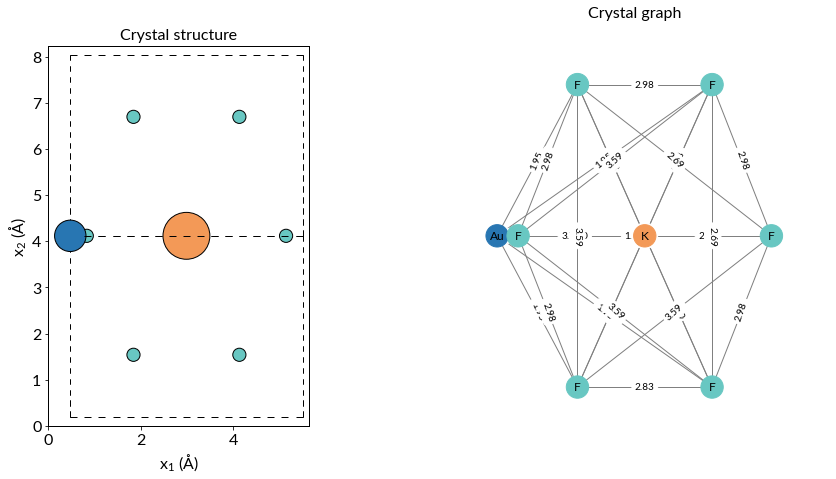

In [10]:
i = 120 # structure index in dataframe
plot_example(df, i=i, label_edges=True)

### Training, validation, and testing datasets
Split the data into training, validation, and testing datasets with balanced representation of different elements in each set.

split train/dev ...


100%|██████████| 64/64 [00:00<00:00, 452.79it/s]


split valid/test ...


100%|██████████| 62/62 [00:00<00:00, 572.15it/s]


number of training examples: 1192
number of validation examples: 137
number of testing examples: 192
total number of examples: 1521


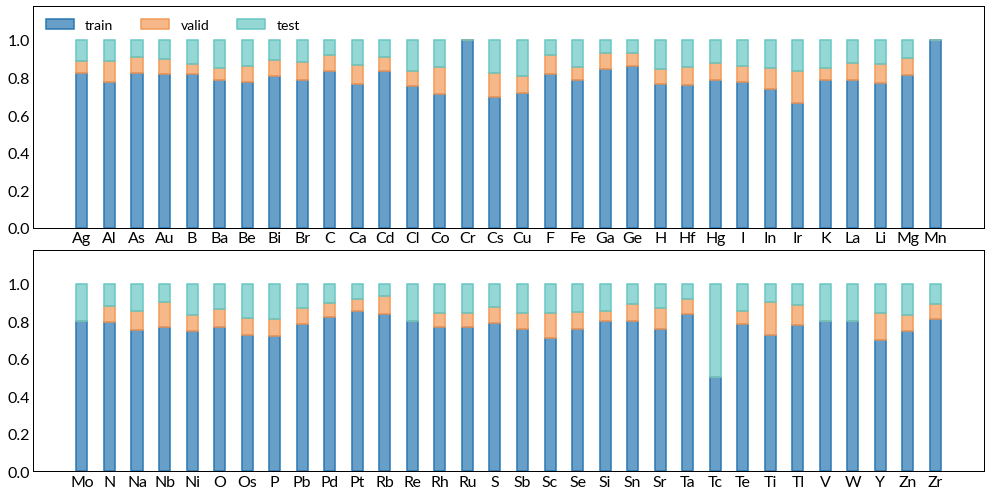

In [11]:
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=0.1, test_size=0.1, seed=12, plot=True)

For use with the trained model provided, the indices of the training, validation, and test sets are loaded below. These indices were generated with a specific seed using the above `train_valid_test_split` function.

In [12]:
with open('data/idx_train.txt', 'w') as f:
    for line in idx_train:
        f.write(str(line))
        f.write('\n')
        
with open('data/idx_valid.txt', 'w') as f:
    for line in idx_valid:
        f.write(str(line))
        f.write('\n')

with open('data/idx_test.txt', 'w') as f:
    for line in idx_test:
        f.write(str(line))
        f.write('\n')

In [13]:
# load train/valid/test indices
with open('data/idx_train.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('data/idx_valid.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('data/idx_test.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# format dataloaders
batch_size = 1
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

average number of neighbors (train/valid/test): 15.003884826325411 / 14.44602851323829 / 14.492637215528783


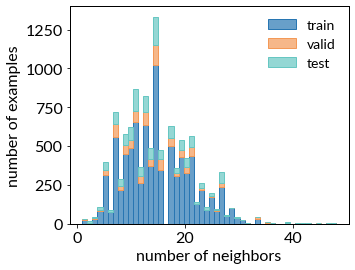

In [26]:
# calculate average number of neighbors
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)
fig.patch.set_facecolor('white')

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

### Network architecture
We build a model based on the `Network` described in the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/api/nn/models/gate_points_2101.html), modified to incorporate the periodic boundaries we imposed on the crystal graphs. The network applies equivariant convolutions to each atomic node and finally takes an average over all nodes, normalizing the output.

In [15]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        # embed the mass-weighted one-hot encoding
        self.em = nn.Linear(in_dim, em_dim)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.x = F.relu(self.em(data.x))
        data.z = F.relu(self.em(data.z))
        output = super().forward(data)
        output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
        
        maxima, _ = torch.max(output, dim=1)
        output = output.div(maxima.unsqueeze(1))
        
        return output

In [16]:
out_dim = len(df.iloc[0]['gph'])
em_dim = 64  

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=1,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e+32x1o | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e | 262144 paths | 262144 weights)
        (fc): FullyConnectedNet[10, 100, 128]
        (tp): TensorProduct(64x0e x 1x0e+1x1o -> 64x0e+64x1o | 128 paths | 128 weights)
        (lin2): FullyConnectedTensorProduct(64x0e+64x1o x 64x0e -> 64x0e+32x1o | 393216 paths | 393216 weights)
      )
      (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 96x0e+32x1o+32x1e | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 32x0e+32x1o | 131072 paths | 131072 weights)
        (fc): FullyConnectedNet[10, 100, 160]
        (tp): TensorProduct(32x0e+32x1o x 1x0e+1x1o -> 64x0e+64x1o+

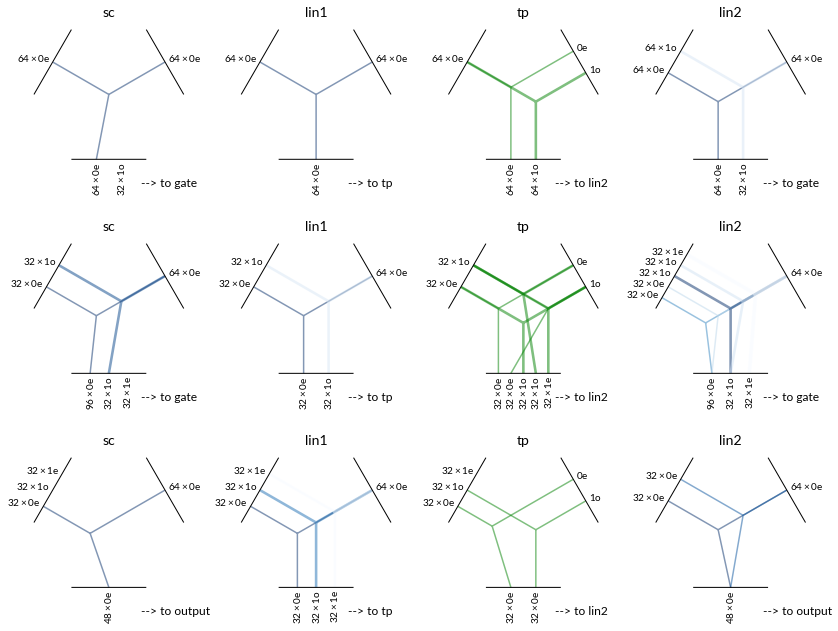

In [27]:
# visualize tensor products of the model
visualize_layers(model)

### Training
The model is trained using a mean-squared error loss function with an Adam optimizer.

In [18]:
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

run_name = 'model_' + time.strftime("%y%m%d", time.localtime())
print(run_name)

torch device: cuda:0
model_220818


In [20]:
len(dataloader_train)

1192

In [21]:
model.pool = True
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
      max_iter=5, scheduler=scheduler, device=device)

100%|██████████| 1192/1192 [00:51<00:00, 23.24it/s]


Iteration    1   train loss = 63347.0009   valid loss = 56716.9410   elapsed time = 00:00:51


100%|██████████| 1192/1192 [00:47<00:00, 24.88it/s]


Iteration    2   train loss = 63347.2249   valid loss = 56717.7564   elapsed time = 00:01:46


100%|██████████| 1192/1192 [00:47<00:00, 24.85it/s]


Iteration    3   train loss = 63346.1613   valid loss = 56716.4560   elapsed time = 00:02:42


100%|██████████| 1192/1192 [00:47<00:00, 25.03it/s]


Iteration    4   train loss = 63349.7579   valid loss = 56720.2508   elapsed time = 00:03:37


100%|██████████| 1192/1192 [00:47<00:00, 24.84it/s]


Iteration    5   train loss = 63351.9753   valid loss = 56722.6393   elapsed time = 00:04:32


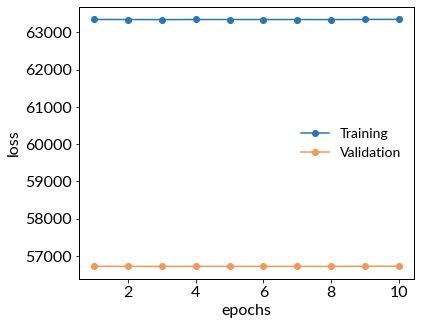

In [28]:
# load pre-trained model and plot its training history
run_name = run_name

history = torch.load(run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, 'o-', label="Training", color=colors['train'])
ax.plot(steps, loss_valid, 'o-', label="Validation", color=colors['valid'])
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);
fig.patch.set_facecolor('white')

### Results
We evaluate our model by visualizing the predicted and true DoS in each error quartile. We further compare the hidden features learned for each node to the partial DoS.

In [23]:
# predict on all data
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['gph_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.gph, reduction='none').mean(dim=-1).cpu().numpy()   #! phdos > gph
        df.loc[i0:i0 + len(d.gph) - 1, 'gph_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.gph) - 1, 'mse'] = loss
        i0 += len(d.gph)
        
df['gph_pred'] = df['gph_pred'].map(lambda x: x[0])

100%|██████████| 24/24 [00:00<00:00, 44.64it/s]


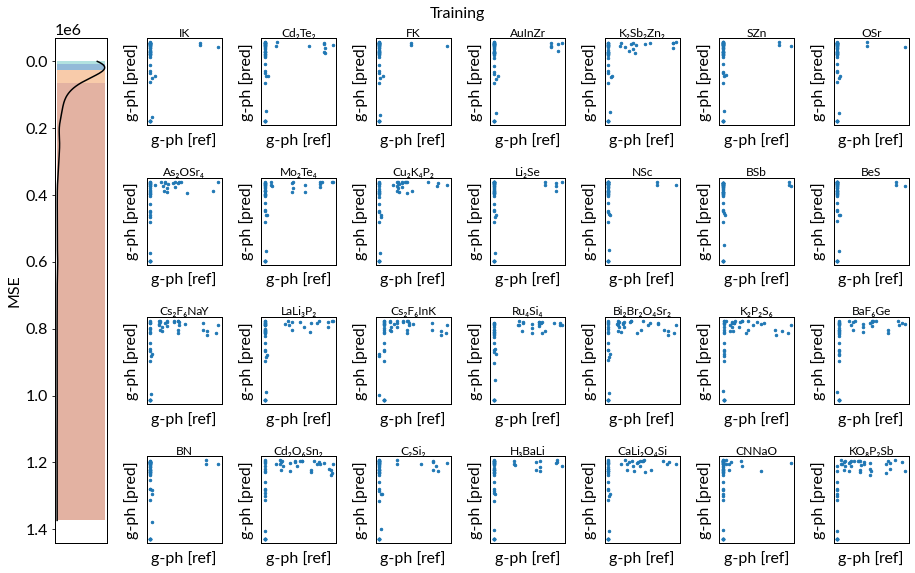

In [67]:
plot_predictions(df, idx_train, 'Training')
plt.savefig(f"savefig/{run_name}_train_out.png")

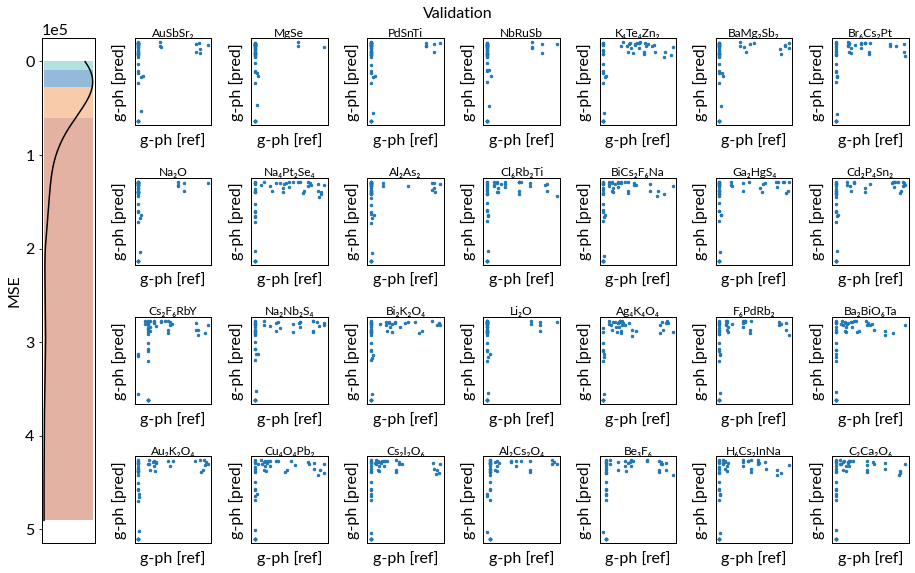

In [68]:
plot_predictions(df, idx_valid, 'Validation')
plt.savefig(f"savefig/{run_name}_valid_out.png")

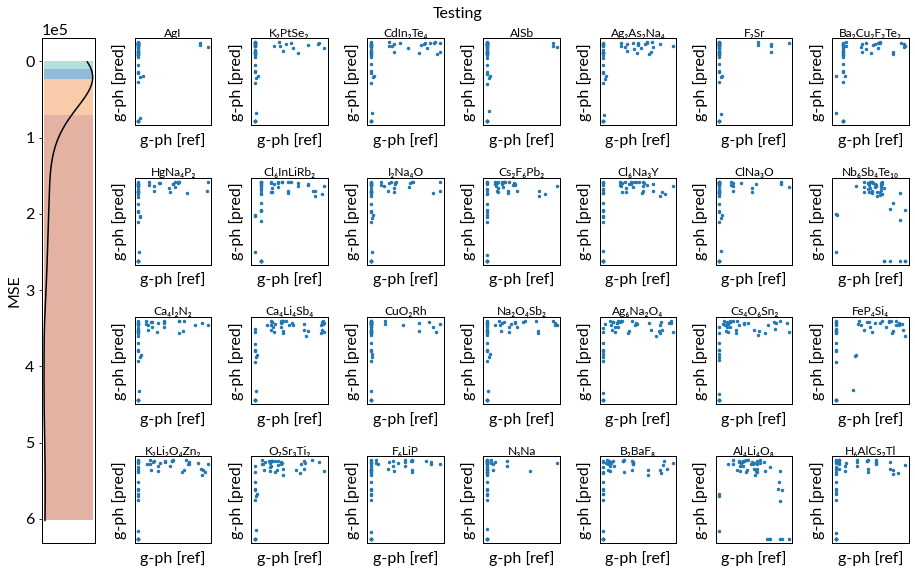

In [69]:
plot_predictions(df, idx_test, 'Testing')
plt.savefig(f"savefig/{run_name}_test_out.png")

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "<eval_with_key>.18", line 34, in forward
    mul = reshape_7 * 0.015625;  reshape_7 = None
    einsum_1 = torch.functional.einsum('cb,ca->cba', mul, reshape_6);  mul = reshape_6 = None
    tensordot = torch.functional.tensordot(einsum_1, reshape_5, ([2, 1], [0, 1]));  einsum_1 = reshape_5 = None
                ~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    reshape_8 = tensordot.reshape(getitem_3, 64);  tensordot = None
    new_zeros = reshape.new_zeros((getitem_3, 96));  reshape = getitem_3 = None
  File "/home/rokabe/anaconda3/envs/pdos/lib/python3.9/site-packages/torch/functional.py", line 1034, in tensordot

    if out is None:
        return _VF.tensordot(a, b, dims_a, dims_b)  # type: ignore[attr-defined]
               ~~~~~~~~~~~~~ <--- HERE
    else:
        return _VF.tensordot(a, b, dims_a, dims_b, out=out)  # type: ignore[attr-defined]
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)


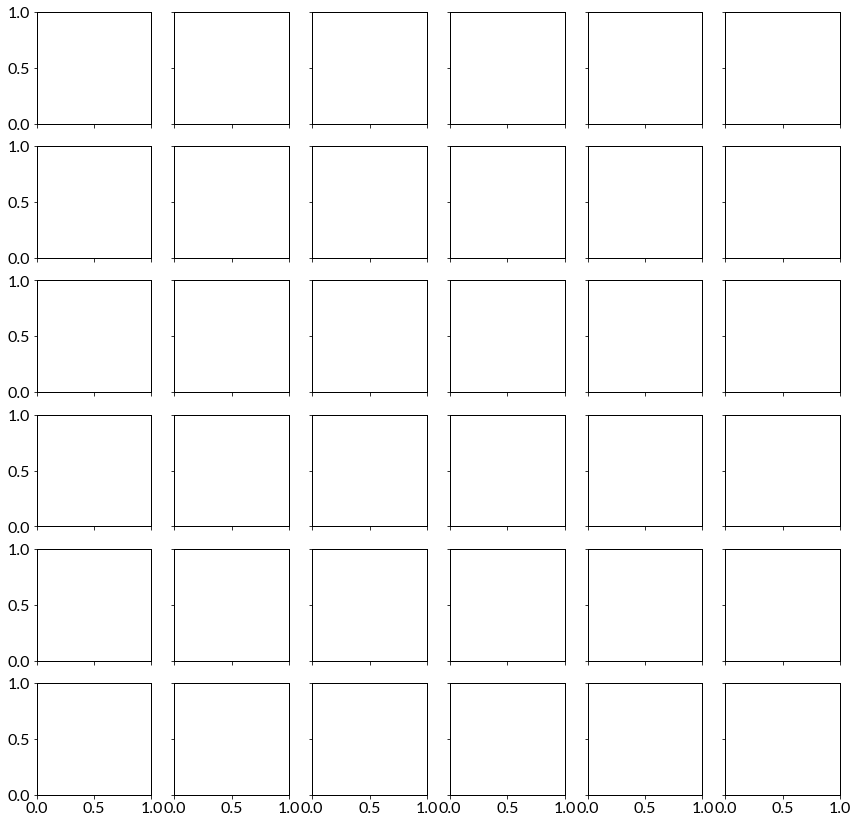

In [66]:
# compare to partial DoS
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = False

# plot example predicted and true partial dos
plot_partials(model, df, idx_train, device=device)

### Alloys
The current framework extends easily to the representation of alloy structures. As an example, we will predict the phonon DoS of the Mg<sub>3</sub>(Bi,Sb)<sub>2</sub> system, incrementally varying the relative fractions of Bi and Sb. Note that both parent compounds, Mg<sub>3</sub>Sb<sub>2</sub> and Mg<sub>3</sub>Bi<sub>2</sub>, are present in our training data. We will check the validity by comparing the predicted and calculated phonon DoS of Mg<sub>3</sub>Bi<sub>1.5</sub>Sb<sub>0.5</sub>.

In [ ]:
# load calculated alloy example
df_alloy, _ = load_data('data/data_alloy.csv')
df_alloy.head()

In [ ]:
# get indices of parent structures
idx_Mg3Sb2 = df.loc[df['mp_id'] == 'mp-2646'].index.to_numpy()[0]
idx_Mg3Bi2 = df.loc[df['mp_id'] == 'mp-569018'].index.to_numpy()[0]
print(f'index of Mg3Sb2: {idx_Mg3Sb2}', f'\nindex of Mg3Bi2: {idx_Mg3Bi2}')

In [ ]:
# interpolate atomic positions and lattice constants
# 2-hot encode the atomic mass, weighted by the fraction of each species
data_alloy = []
x_Bi = np.linspace(0.01, 0.99, 99)

for i, p in tqdm(enumerate(x_Bi), total=len(x_Bi), bar_format=bar_format):
    symbols = df['data'][idx_Mg3Bi2].symbol.copy()
    positions = torch.lerp(df['data'][idx_Mg3Sb2].pos.clone(), df['data'][idx_Mg3Bi2].pos.clone(), p)
    lattice = torch.lerp(df['data'][idx_Mg3Sb2].lattice.clone(), df['data'][idx_Mg3Bi2].lattice.clone(), p)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    struct = df.iloc[idx_Mg3Bi2].structure.copy()
    struct.positions = positions.numpy().copy()
    struct.cell = lattice.numpy().squeeze().copy()
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=struct, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data_alloy.append(
            tg.data.Data(
            pos=positions, 
            lattice=lattice, 
            symbol=symbols,
            x=torch.lerp(df['data'][idx_Mg3Sb2].x, df['data'][idx_Mg3Bi2].x, p),
            z=torch.lerp(df['data'][idx_Mg3Sb2].z, df['data'][idx_Mg3Bi2].z, p),
            edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
            edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
            edge_vec=edge_vec, edge_len=edge_len,
            phdos=df['data'][idx_Mg3Bi2].phdos.clone()
        )
    )

In [ ]:
# predict on all alloy structures
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader([df.iloc[idx_Mg3Sb2]['data']] + data_alloy + [df.iloc[idx_Mg3Bi2]['data']],
                                  batch_size=32)

output = np.zeros((len(data_alloy) + 2, len(df_alloy['phdos'][0])))
model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output[i0:i0 + len(d.phdos),:] = model(d).cpu().numpy()
        i0 += len(d.phdos)

In [ ]:
# plot predictions, and compare with calculated result for selected compound
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios': [1,2]})
color = cmap(np.linspace(0, 1, len(output)))
f = df_alloy['phfreq'][0]

# waterfall plot of alloy predictions
s = 2./len(x_Bi)
for i in range(len(output)):
    ax1.plot(f, output[i]/output[i].max() + i*s, c=color[i])
ax1.set_yticklabels([])
ax1.set_xlabel('$Frequency\ (cm^{-1})$')
ax1.set_ylabel('$Intensity$')

sm = mpl.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cax = inset_axes(ax1, width="40%", height="4%", loc=3, bbox_to_anchor=(0.5,0.9,1,1), bbox_transform=ax1.transAxes) 
cbar = fig.colorbar(sm, cax=cax, aspect=16, orientation='horizontal', pad=-0.1)
cbar.ax.set_xlabel('$x_{Bi}$', fontsize=16, labelpad=-5)
    
# comparison to calculation
p = x_Bi.tolist().index(0.75)
ax2.remove()
ax2 = fig.add_subplot(122, projection='3d')

# plot calculations
ax2.plot(f, [0.75]*len(f), df_alloy['phdos'][0], lw=1.5, c='black', label='Calculated')
ax2.plot(f, [0]*len(f), df.iloc[idx_Mg3Sb2]['phdos'], lw=1.5, c='black')
ax2.plot(f, [1]*len(f), df.iloc[idx_Mg3Bi2]['phdos'], lw=1.5, c='black')

# plot predictions
ax2.plot(f, [0.75]*len(f), output[p]/output[p].max(), lw=2, c=palette[1], label='Predicted (alloy)')
ax2.plot(f, [0]*len(f), output[0]/output[0].max(), lw=2, c=palette[0], label='Predicted (pure)')
ax2.plot(f, [1]*len(f), output[-1]/output[-1].max(), lw=2, c=palette[0])

ax2.view_init(elev=20, azim=-50)
ax2.w_xaxis.set_pane_color((1., 1., 1., 1.))
ax2.w_yaxis.set_pane_color((1., 1., 1., 1.))
ax2.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.))
ax2.grid(False)
ax2.w_xaxis.line.set_color('dimgray'); ax2.w_yaxis.line.set_color('dimgray'); ax2.w_zaxis.line.set_color('dimgray')
    
ax2.set_xlabel('$Frequency\ (cm^{-1})$', labelpad=14)
ax2.set_ylabel('$x_{Bi}$', labelpad=10)
ax2.set_zlabel('$Intensity$', labelpad=10)
ax2.legend(frameon=False, bbox_to_anchor=(0.9,0.4), bbox_transform=fig.transFigure);

### Visualization of intermediate features
We can visualize the intermediate features on each node projected onto the basis of spherical harmonics.

In [ ]:
d = next(iter(dataloader_train))
specie = d.symbol[0]
sts, st_feats = get_middle_feats(d, model, normalize=True)

for sts_idx in range(len(sts)):
    traces, traces_species = plotly_surface(sts[sts_idx], st_feats[sts_idx].detach().cpu(), centers=d.pos.cpu(),
                                            res=20, radius=True, species=specie)
    fig_html = plot_orbitals(traces, traces_species, title_str=f'feature: {str(sts[sts_idx])}')
    
    with open(f'feature_{str(sts[sts_idx])}.html', 'w') as f:
        f.write(fig_html)

imgs = [f'feature_{str(sts[sts_idx])}.html' for sts_idx in range(len(sts))]

for img in imgs:
    display(HTML(filename=img))